<a href="https://colab.research.google.com/github/ghommidhWassim/GNN-variants/blob/main/graphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torchvision
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
2.6.0+cu124
12.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    F

In [39]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd
import time
# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
from torch_sparse import spmm
# import pyg_lib
import torch_sparse

# PyTorch geometric
from torch_geometric.nn import GCNConv,SAGEConv
from torch_geometric.datasets import Planetoid,Amazon
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
import torch_geometric.transforms as T
from torch_geometric import seed_everything
import torch
import os.path as osp
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

def clean_gpu_memory():
    """Cleans GPU memory without fully resetting the CUDA context"""
    import gc
    gc.collect()  # Python garbage collection
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # PyTorch cache
        torch.cuda.reset_peak_memory_stats()  # Reset tracking
        print(f"Memory after cleanup: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

num_features, data, num_classes, device, dataset = dataset_load()
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')
num_features

Using device: cuda


Processing...
Done!


Number of nodes:          19717
Number of edges:          88648
Average node degree:      4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


500

In [4]:
print(f"Allocated memory : {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory : {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")


Allocated memory : 39.56 MB
Reserved memory : 62.00 MB
Peak allocated memory: 45.02 MB


In [44]:
clean_gpu_memory()

Memory after cleanup: 167.96 MB


In [6]:
train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[10, 10],  # s = 10 per layer (2 layers)
    batch_size=128,
    shuffle=True,
)


In [7]:
print(f"Allocated memory : {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory : {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")

Allocated memory : 39.56 MB
Reserved memory : 62.00 MB
Peak allocated memory: 42.99 MB


In [8]:
class testGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = torch.nn.ModuleList()
        # First layer: in_channels -> hidden_channels
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        # Intermediate layers: hidden_channels -> hidden_channels
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        # Last layer: hidden_channels -> out_channels (optional, if no linear layers)
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        # Optional MLP head (for further transformation)
        self.lin1 = Linear(out_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = F.relu(conv(x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Last layer (no ReLU/Dropout for classification)
        x = self.convs[-1](x, edge_index)

        # Optional MLP head
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)

        return F.log_softmax(x, dim=1)

In [9]:
hidden_channels = 64

model = testGraphSAGE(
    in_channels=dataset.num_features,  # Input feature dimension
    hidden_channels=64,               # Hidden layer size
    num_layers=2,                     # Number of SAGEConv layers
    out_channels=dataset.num_classes,  # Output dimension (number of classes)
    dropout=0.5,                      # Dropout rate                         # Jumping Knowledge (optional: "cat", "max", "lstm")
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()  # Negative Log Likelihood (used with log_softmax)


In [10]:
# Minibatch training function
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Full-batch evaluation (for simplicity)
def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        acc = (pred == data.y[mask]).float().mean().item()
    return acc

In [11]:
# Training loop
start_time = time.time()

allocated_mem = []
reserved_mem = []
peak_mem = []
for epoch in range(1, 101):
    #torch.cuda.reset_peak_memory_stats()  # reset peak tracking
    loss = train()
    val_acc = evaluate(data.val_mask)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

    alloc = torch.cuda.memory_allocated() / 1024**2
    reserv = torch.cuda.memory_reserved() / 1024**2
    peak = torch.cuda.max_memory_allocated() / 1024**2

    allocated_mem.append(alloc)
    reserved_mem.append(reserv)
    peak_mem.append(peak)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test accuracy
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch: 001, Loss: 1.1149, Val Acc: 0.1960
Epoch: 002, Loss: 1.1030, Val Acc: 0.2040
Epoch: 003, Loss: 1.0959, Val Acc: 0.5060
Epoch: 004, Loss: 1.0900, Val Acc: 0.2760
Epoch: 005, Loss: 1.1024, Val Acc: 0.4720
Epoch: 006, Loss: 1.0964, Val Acc: 0.5400
Epoch: 007, Loss: 1.0610, Val Acc: 0.5700
Epoch: 008, Loss: 1.0622, Val Acc: 0.6480
Epoch: 009, Loss: 1.0446, Val Acc: 0.7080
Epoch: 010, Loss: 0.9879, Val Acc: 0.7320
Epoch: 011, Loss: 0.9862, Val Acc: 0.7100
Epoch: 012, Loss: 0.9494, Val Acc: 0.6940
Epoch: 013, Loss: 0.8916, Val Acc: 0.6560
Epoch: 014, Loss: 0.8399, Val Acc: 0.6340
Epoch: 015, Loss: 0.7710, Val Acc: 0.6360
Epoch: 016, Loss: 0.6743, Val Acc: 0.6440
Epoch: 017, Loss: 0.6458, Val Acc: 0.6460
Epoch: 018, Loss: 0.5323, Val Acc: 0.6660
Epoch: 019, Loss: 0.4600, Val Acc: 0.6860
Epoch: 020, Loss: 0.4175, Val Acc: 0.7020
Epoch: 021, Loss: 0.4039, Val Acc: 0.7220
Epoch: 022, Loss: 0.3220, Val Acc: 0.7280
Epoch: 023, Loss: 0.2537, Val Acc: 0.7260
Epoch: 024, Loss: 0.2062, Val Acc:

In [12]:
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7610


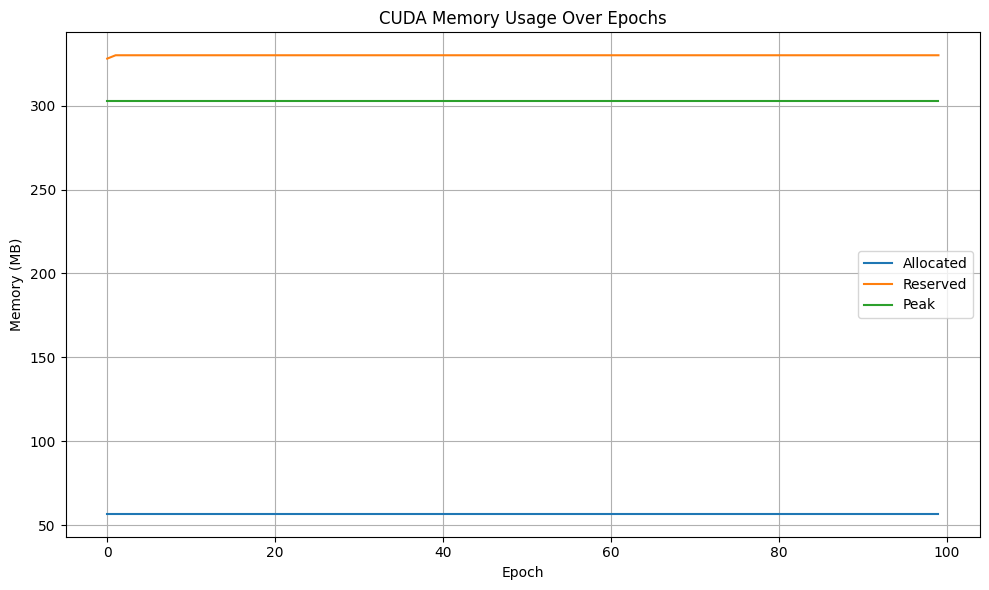

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(allocated_mem, label='Allocated')
plt.plot(reserved_mem, label='Reserved')
plt.plot(peak_mem, label='Peak')
plt.xlabel('Epoch')
plt.ylabel('Memory (MB)')
plt.title('CUDA Memory Usage Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import math

def calculate_graphsage_memory(
    num_layers: int,
    hidden_dim: int,
    num_classes: int,
    batch_size: int,
    num_neighbors: list,
    dtype_bytes: int = 4,  # float32=4, float16=2
    verbose: bool = True
) -> dict:
    """
    Calculate memory usage for GraphSAGE based on:
    - Weight matrices: O(LK²)
    - Intermediate embeddings: Batch size × Neighbor fanout × Hidden dim

    Args:
        num_layers: Number of SAGEConv layers (L)
        hidden_dim: Hidden dimension size (K)
        num_classes: Output dimension size (C)
        batch_size: Number of seed nodes (B)
        num_neighbors: List of neighbors per layer (e.g., [25, 10] for 2 layers)
        dtype_bytes: Bytes per parameter (4 for float32, 2 for float16)
        verbose: Print detailed breakdown

    Returns:
        Dictionary with memory components in MB
    """
    # --- Weight Matrices (O(LK²)) ---
    # Input-to-hidden: K×K
    # Hidden-to-output: K×C
    weight_memory = (num_layers * hidden_dim**2 + hidden_dim * num_classes) * dtype_bytes
    weight_memory_mb = weight_memory / (1024 ** 2)

    # --- Intermediate Embeddings ---
    # Layer 0: seed nodes
    current_nodes = batch_size
    embedding_memory = 0

    for l in range(num_layers):
        # Nodes in this layer = current_nodes × neighbors[l]
        current_nodes *= num_neighbors[l]
        # Memory = nodes × hidden_dim × bytes
        layer_memory = current_nodes * hidden_dim * dtype_bytes
        embedding_memory += layer_memory

        if verbose:
            print(f"Layer {l+1}: {current_nodes:,} nodes → {layer_memory/(1024**2):.2f} MB")

    embedding_memory_mb = embedding_memory / (1024 ** 2)

    # --- Total ---
    total_memory_mb = weight_memory_mb + embedding_memory_mb

    if verbose:
        print("\nMemory Breakdown:")
        print(f"- Weights:    {weight_memory_mb:.4f} MB")
        print(f"- Embeddings: {embedding_memory_mb:.2f} MB")
        print(f"Total:       {total_memory_mb:.2f} MB")

    return {
        'weights_mb': weight_memory_mb,
        'embeddings_mb': embedding_memory_mb,
        'total_mb': total_memory_mb,
        'peak_nodes': current_nodes
    }

# Example usage for PubMed dataset
if __name__ == "__main__":
    config = {
        'num_layers': 2,
        'hidden_dim': 64,
        'num_classes': num_classes,
        'batch_size': 128,
        'num_neighbors': [10, 10],
        'dtype_bytes': 4  # float32
    }

    memory_stats = calculate_graphsage_memory(**config)

Layer 1: 1,280 nodes → 0.31 MB
Layer 2: 12,800 nodes → 3.12 MB

Memory Breakdown:
- Weights:    0.0320 MB
- Embeddings: 3.44 MB
Total:       3.47 MB


In [15]:
from torch.profiler import profile, record_function, ProfilerActivity

def profile_memory_usage(model, data_loader):
    with profile(
        activities=[ProfilerActivity.CUDA],  # Track CUDA memory
        profile_memory=True,
        record_shapes=True
    ) as prof:
        for batch in data_loader:
            with record_function("forward_pass"):
                out = model(batch.x, batch.edge_index)
            with record_function("backward_pass"):
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                loss.backward()

    # Print memory summary
    print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))

In [16]:
print(f"Allocated memory : {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory : {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")


Allocated memory : 56.81 MB
Reserved memory : 330.00 MB
Peak allocated memory: 302.89 MB


In [17]:
summ=torch.cuda.memory_summary()

In [18]:
summ

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  58174 KiB | 310156 KiB |  34238 MiB |  34181 MiB |\n|       from large pool |  56937 KiB | 308841 KiB |  32384 MiB |  32328 MiB |\n|       from small pool |   1237 KiB |   3987 KiB |   1853 MiB |   1852 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  58174 KiB | 310156 KiB |  34238 MiB |  34181 MiB |\n|       from large pool |  56937 KiB | 308841 KiB |

In [19]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"
import json

metrics = {
    "model": "graphSAGE",
    "accuracy": "0.7200",
    "memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time
}

with open("graphSAGE_results.json", "w") as f:
    json.dump(metrics, f)

In [20]:
import math

def calculate_graphsage_memory(
    batch_size: int,
    hidden_dim: int,
    num_layers: int,
    num_neighbors: int,
    num_features: int = None,
    num_classes: int = None,
    dtype_bytes: int = 4,  # float32=4, float16=2
    verbose: bool = True
) -> dict:
    """
    Calculate memory consumption for GraphSAGE according to LADIES paper's formulation:
    - Embedding storage: O(b * K * s^{L-1})
    - Weight matrices: O(L * K^2)

    Where:
        b = batch_size,
        K = hidden_dim,
        s = num_neighbors (per layer),
        L = num_layers

    Args:
        batch_size (int): Number of seed nodes (b).
        hidden_dim (int): Hidden dimension size (K).
        num_layers (int): Number of layers (L).
        num_neighbors (int): Neighbor sample size per layer (s).
        num_features (int): Input feature dimension (optional, for first layer weights).
        num_classes (int): Output dimension (optional, for last layer weights).
        dtype_bytes (int): Bytes per parameter (4 for float32, 2 for float16).
        verbose (bool): Print detailed breakdown.

    Returns:
        dict: Memory components in bytes and MB.
    """
    # --- Embedding Storage (O(b * K * s^{L-1})) ---
    embedding_memory_bytes = batch_size * hidden_dim * (num_neighbors ** (num_layers - 1)) * dtype_bytes

    # --- Weight Matrices (O(L * K^2)) ---
    # First layer: (num_features -> hidden_dim) if provided
    if num_features is not None:
        weight_memory_bytes = num_features * hidden_dim * dtype_bytes
        remaining_layers = num_layers - 1
    else:
        weight_memory_bytes = 0
        remaining_layers = num_layers

    # Hidden layers: L-1 layers of (K x K)
    weight_memory_bytes += remaining_layers * (hidden_dim * hidden_dim) * dtype_bytes

    # Output layer: (K -> num_classes) if provided
    if num_classes is not None:
        weight_memory_bytes += hidden_dim * num_classes * dtype_bytes

    total_memory_bytes = embedding_memory_bytes + weight_memory_bytes

    # Convert to MB
    embedding_memory_mb = embedding_memory_bytes / (1024 ** 2)
    weight_memory_mb = weight_memory_bytes / (1024 ** 2)
    total_memory_mb = total_memory_bytes / (1024 ** 2)

    if verbose:
        print("\n=== GraphSAGE Memory Breakdown ===")
        print(f"Batch size (b): {batch_size}")
        print(f"Hidden dim (K): {hidden_dim}")
        print(f"Layers (L): {num_layers}")
        print(f"Neighbors (s): {num_neighbors}")
        print(f"Data type: {'float32' if dtype_bytes == 4 else 'float16'}")
        print("\nEmbedding Storage:")
        print(f"- Formula: O(b * K * s^(L-1)) = {batch_size} * {hidden_dim} * {num_neighbors}^({num_layers}-1)")
        print(f"- Memory: {embedding_memory_bytes:,} bytes ({embedding_memory_mb:.2f} MB)")
        print("\nWeight Matrices:")
        print(f"- Formula: O(L * K^2) = {num_layers} * {hidden_dim}^2")
        if num_features is not None:
            print(f"  (First layer: {num_features} -> {hidden_dim})")
        if num_classes is not None:
            print(f"  (Last layer: {hidden_dim} -> {num_classes})")
        print(f"- Memory: {weight_memory_bytes:,} bytes ({weight_memory_mb:.2f} MB)")
        print("\nTotal Memory:")
        print(f"- Total: {total_memory_bytes:,} bytes ({total_memory_mb:.2f} MB)")

    return {
        'embedding_bytes': embedding_memory_bytes,
        'weight_bytes': weight_memory_bytes,
        'total_bytes': total_memory_bytes,
        'embedding_mb': embedding_memory_mb,
        'weight_mb': weight_memory_mb,
        'total_mb': total_memory_mb,
        'formula': {
            'embedding': f'O(b*K*s^(L-1)) = {batch_size}*{hidden_dim}*{num_neighbors}^({num_layers-1})',
            'weights': f'O(L*K^2) = {num_layers}*{hidden_dim}^2'
        }
    }


# Example usage
if __name__ == "__main__":
    # PubMed dataset example
    memory_stats = calculate_graphsage_memory(
        batch_size=128,
        hidden_dim=64,
        num_layers=2,
        num_neighbors=10,
        num_features=500,  # PubMed node features
        num_classes=3,     # PubMed classes
        dtype_bytes=4      # float32
    )


=== GraphSAGE Memory Breakdown ===
Batch size (b): 128
Hidden dim (K): 64
Layers (L): 2
Neighbors (s): 10
Data type: float32

Embedding Storage:
- Formula: O(b * K * s^(L-1)) = 128 * 64 * 10^(2-1)
- Memory: 327,680 bytes (0.31 MB)

Weight Matrices:
- Formula: O(L * K^2) = 2 * 64^2
  (First layer: 500 -> 64)
  (Last layer: 64 -> 3)
- Memory: 145,152 bytes (0.14 MB)

Total Memory:
- Total: 472,832 bytes (0.45 MB)


**CORA** **Dataset**

In [21]:
def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()
print(f'Number of features:       {num_features}')
print(f'Number of classes:       {num_classes}')

print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')

train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[10, 10],  # s = 10 per layer (2 layers)
    batch_size=128,
    shuffle=True,
)
hidden_channels = 64

model = testGraphSAGE(
    in_channels=dataset.num_features,  # Input feature dimension
    hidden_channels=64,               # Hidden layer size
    num_layers=2,                     # Number of SAGEConv layers
    out_channels=dataset.num_classes,  # Output dimension (number of classes)
    dropout=0.5,                      # Dropout rate                         # Jumping Knowledge (optional: "cat", "max", "lstm")
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()  # Negative Log Likelihood (used with log_softmax)
# Training loop
start_time = time.time()

allocated_mem = []
reserved_mem = []
peak_mem = []
for epoch in range(1, 101):
    #torch.cuda.reset_peak_memory_stats()  # reset peak tracking
    loss = train()
    val_acc = evaluate(data.val_mask)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

    alloc = torch.cuda.memory_allocated() / 1024**2
    reserv = torch.cuda.memory_reserved() / 1024**2
    peak = torch.cuda.max_memory_allocated() / 1024**2

    allocated_mem.append(alloc)
    reserved_mem.append(reserv)
    peak_mem.append(peak)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test accuracy
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")

Using device: cuda


Processing...
Done!


Number of features:       1433
Number of classes:       7
Number of nodes:          2708
Number of edges:          10556
Average node degree:      3.90
Number of training nodes: 140
Training node label rate: 0.052
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True
Epoch: 001, Loss: 1.9287, Val Acc: 0.0580
Epoch: 002, Loss: 1.9194, Val Acc: 0.1000
Epoch: 003, Loss: 1.9300, Val Acc: 0.0720
Epoch: 004, Loss: 1.9351, Val Acc: 0.0720
Epoch: 005, Loss: 1.9217, Val Acc: 0.1240
Epoch: 006, Loss: 1.9167, Val Acc: 0.0900
Epoch: 007, Loss: 1.8875, Val Acc: 0.1160
Epoch: 008, Loss: 1.8894, Val Acc: 0.2960
Epoch: 009, Loss: 1.7469, Val Acc: 0.3400
Epoch: 010, Loss: 1.7367, Val Acc: 0.3100
Epoch: 011, Loss: 1.6611, Val Acc: 0.3280
Epoch: 012, Loss: 1.5023, Val Acc: 0.3580
Epoch: 013, Loss: 1.3842, Val Acc: 0.3920
Epoch: 014, Loss: 1.2098, Val Acc: 0.4620
Epoch: 015, Loss: 1.1357, Val Acc: 0.4540
Epoch: 016, Loss: 0.9955, Val Acc: 0.5100
Epoch: 017, Loss: 0

In [22]:
if __name__ == "__main__":
    # PubMed dataset example
    memory_stats = calculate_graphsage_memory(
        batch_size=128,
        hidden_dim=64,
        num_layers=2,
        num_neighbors=10,
        num_features=1433,  # CORA node features
        num_classes=7,     # CORA classes
        dtype_bytes=4      # float32
    )


=== GraphSAGE Memory Breakdown ===
Batch size (b): 128
Hidden dim (K): 64
Layers (L): 2
Neighbors (s): 10
Data type: float32

Embedding Storage:
- Formula: O(b * K * s^(L-1)) = 128 * 64 * 10^(2-1)
- Memory: 327,680 bytes (0.31 MB)

Weight Matrices:
- Formula: O(L * K^2) = 2 * 64^2
  (First layer: 1433 -> 64)
  (Last layer: 64 -> 7)
- Memory: 385,024 bytes (0.37 MB)

Total Memory:
- Total: 712,704 bytes (0.68 MB)


**CiteSeer DATASET**

In [23]:
def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()
print(f'Number of features:       {num_features}')
print(f'Number of classes:       {num_classes}')

print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')

train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[10, 10],  # s = 10 per layer (2 layers)
    batch_size=128,
    shuffle=True,
)
hidden_channels = 64

model = testGraphSAGE(
    in_channels=dataset.num_features,  # Input feature dimension
    hidden_channels=64,               # Hidden layer size
    num_layers=2,                     # Number of SAGEConv layers
    out_channels=dataset.num_classes,  # Output dimension (number of classes)
    dropout=0.5,                      # Dropout rate                         # Jumping Knowledge (optional: "cat", "max", "lstm")
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()  # Negative Log Likelihood (used with log_softmax)
# Training loop
start_time = time.time()

allocated_mem = []
reserved_mem = []
peak_mem = []
for epoch in range(1, 101):
    #torch.cuda.reset_peak_memory_stats()  # reset peak tracking
    loss = train()
    val_acc = evaluate(data.val_mask)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

    alloc = torch.cuda.memory_allocated() / 1024**2
    reserv = torch.cuda.memory_reserved() / 1024**2
    peak = torch.cuda.max_memory_allocated() / 1024**2

    allocated_mem.append(alloc)
    reserved_mem.append(reserv)
    peak_mem.append(peak)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test accuracy
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")

Using device: cuda


Processing...
Done!


Number of features:       3703
Number of classes:       6
Number of nodes:          3327
Number of edges:          9104
Average node degree:      2.74
Number of training nodes: 120
Training node label rate: 0.036
Has isolated nodes:       True
Has self-loops:           False
Is undirected:            True
Epoch: 001, Loss: 1.8096, Val Acc: 0.2120
Epoch: 002, Loss: 1.7996, Val Acc: 0.2120
Epoch: 003, Loss: 1.7890, Val Acc: 0.1720
Epoch: 004, Loss: 1.7975, Val Acc: 0.1720
Epoch: 005, Loss: 1.7924, Val Acc: 0.1740
Epoch: 006, Loss: 1.7743, Val Acc: 0.1560
Epoch: 007, Loss: 1.7653, Val Acc: 0.2360
Epoch: 008, Loss: 1.7451, Val Acc: 0.2100
Epoch: 009, Loss: 1.7322, Val Acc: 0.2760
Epoch: 010, Loss: 1.7148, Val Acc: 0.2720
Epoch: 011, Loss: 1.6664, Val Acc: 0.2820
Epoch: 012, Loss: 1.6534, Val Acc: 0.2920
Epoch: 013, Loss: 1.6130, Val Acc: 0.3940
Epoch: 014, Loss: 1.5129, Val Acc: 0.5160
Epoch: 015, Loss: 1.4756, Val Acc: 0.5200
Epoch: 016, Loss: 1.4178, Val Acc: 0.4940
Epoch: 017, Loss: 1.3

In [24]:
if __name__ == "__main__":
    # PubMed dataset example
    memory_stats = calculate_graphsage_memory(
        batch_size=128,
        hidden_dim=64,
        num_layers=2,
        num_neighbors=10,
        num_features=3703,  # CiteSeer node features
        num_classes=6,     # CiteSeer classes
        dtype_bytes=4      # float32
    )


=== GraphSAGE Memory Breakdown ===
Batch size (b): 128
Hidden dim (K): 64
Layers (L): 2
Neighbors (s): 10
Data type: float32

Embedding Storage:
- Formula: O(b * K * s^(L-1)) = 128 * 64 * 10^(2-1)
- Memory: 327,680 bytes (0.31 MB)

Weight Matrices:
- Formula: O(L * K^2) = 2 * 64^2
  (First layer: 3703 -> 64)
  (Last layer: 64 -> 6)
- Memory: 965,888 bytes (0.92 MB)

Total Memory:
- Total: 1,293,568 bytes (1.23 MB)


** Amazon DATASET**

In [45]:
def dataset_load():
  print(f"Using device: {device}")
  dataset = Amazon(
        root='data/Amazon',
        name='Computers',
        transform=T.Compose([
        NormalizeFeatures(),          # feature‑wise ℓ₂ normalisation
        RandomNodeSplit(              # ⇦ add a split transform
                split='train_rest',       # 10% val, 10% test by default
                num_val=0.1,
                num_test=0.1,
                num_splits=1,
            )
        ])
    )
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()
print(f'Number of features:       {num_features}')
print(f'Number of classes:       {num_classes}')

print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f"Training nodes: {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")
#print(f'Number of training nodes: {data.train_mask.sum()}')
#print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
#print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
#print(f'Has self-loops:           {data.has_self_loops()}')
#print(f'Is undirected:            {data.is_undirected()}')
train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[10, 10],  # s = 10 per layer (2 layers)
    batch_size=128,
    shuffle=True,
)
hidden_channels = 64

model = testGraphSAGE(
    in_channels=dataset.num_features,  # Input feature dimension
    hidden_channels=64,               # Hidden layer size
    num_layers=2,                     # Number of SAGEConv layers
    out_channels=dataset.num_classes,  # Output dimension (number of classes)
    dropout=0.5,                      # Dropout rate                         # Jumping Knowledge (optional: "cat", "max", "lstm")
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()  # Negative Log Likelihood (used with log_softmax)
# Training loop
start_time = time.time()

allocated_mem = []
reserved_mem = []
peak_mem = []
for epoch in range(1, 101):
    #torch.cuda.reset_peak_memory_stats()  # reset peak tracking
    loss = train()
    val_acc = evaluate(data.val_mask)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

    alloc = torch.cuda.memory_allocated() / 1024**2
    reserv = torch.cuda.memory_reserved() / 1024**2
    peak = torch.cuda.max_memory_allocated() / 1024**2

    allocated_mem.append(alloc)
    reserved_mem.append(reserv)
    peak_mem.append(peak)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test accuracy
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")

Using device: cuda
Number of features:       767
Number of classes:       10
Number of nodes:          13752
Number of edges:          491722
Average node degree:      35.76
Training nodes: 11002
Validation nodes: 1375
Test nodes: 1375
Epoch: 001, Loss: 1.7805, Val Acc: 0.5498
Epoch: 002, Loss: 1.3485, Val Acc: 0.5782
Epoch: 003, Loss: 1.1682, Val Acc: 0.6422
Epoch: 004, Loss: 1.0022, Val Acc: 0.7105
Epoch: 005, Loss: 0.8929, Val Acc: 0.7338
Epoch: 006, Loss: 0.8165, Val Acc: 0.7433
Epoch: 007, Loss: 0.7603, Val Acc: 0.7542
Epoch: 008, Loss: 0.7749, Val Acc: 0.7135
Epoch: 009, Loss: 0.7432, Val Acc: 0.7389
Epoch: 010, Loss: 0.7273, Val Acc: 0.7295
Epoch: 011, Loss: 0.7148, Val Acc: 0.7520
Epoch: 012, Loss: 0.7158, Val Acc: 0.7549
Epoch: 013, Loss: 0.7041, Val Acc: 0.7578
Epoch: 014, Loss: 0.7164, Val Acc: 0.7520
Epoch: 015, Loss: 0.6983, Val Acc: 0.7549
Epoch: 016, Loss: 0.6902, Val Acc: 0.7542
Epoch: 017, Loss: 0.6965, Val Acc: 0.7571
Epoch: 018, Loss: 0.6906, Val Acc: 0.7556
Epoch: 0

In [41]:
if __name__ == "__main__":
    # amazon dataset example
    memory_stats = calculate_graphsage_memory(
        batch_size=128,
        hidden_dim=64,
        num_layers=2,
        num_neighbors=10,
        num_features=767,  # AMAZON node features
        num_classes=10,     # AMAZON classes
        dtype_bytes=4      # float32
    )


=== GraphSAGE Memory Breakdown ===
Batch size (b): 128
Hidden dim (K): 64
Layers (L): 2
Neighbors (s): 10
Data type: float32

Embedding Storage:
- Formula: O(b * K * s^(L-1)) = 128 * 64 * 10^(2-1)
- Memory: 327,680 bytes (0.31 MB)

Weight Matrices:
- Formula: O(L * K^2) = 2 * 64^2
  (First layer: 767 -> 64)
  (Last layer: 64 -> 10)
- Memory: 215,296 bytes (0.21 MB)

Total Memory:
- Total: 542,976 bytes (0.52 MB)
